# Comparing SFH posterior estimates on Yirui's galaxy using different levels of SNR
The full datacube-summed spectrum was perturbed with SNRs of 5, 10, 15 and 20, plus assigned observational uncertainties accordingly. Now after fitting them through bagpippes with the parametric SFH model, we can analyze their accuracies through comparing SFH parameters (f burst, t burst, total mass formed, etc) in order to inform the cutoff SNR chosen for fitting MaNGA SEDs spaxel-by-spaxel.

In [17]:
import numpy as np 
import pandas as pd
import bagpipes as pipes

from astropy.io import fits
from PyAstronomy import pyasl
import sys
sys.path.append('/home/hin/Documents/St_Andrews/dense_basis')
import dense_basis as db

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks,peak_prominences

### First loading in all the various functions

In [18]:
def bin(spectrum, binn):
    """ Bins up two or three column spectral data by a specified factor. """

    binn = int(binn)
    nbins = len(spectrum)/binn
    binspec = np.zeros((int(nbins), spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec

def mask_em(wave):
    """ from maskem.pro OII, Hgama, Hbeta, OIII, OIII: Vacuum """

    
    lines_vac = np.array([3727.092,3729.875,4102.892, 4341.692,4862.683,4960.295,5008.24])
    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        masksize = 5

        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    # MgII  2796.352 ,2803.531 
    #ind = np.where((wave>2766.4) & (wave<2833.5))

    # remove everything bluewards of 3000A
    ind = np.where(wave<3000)
    mask.extend(ind[0])    

    return mask

def load_uds_spectrum_mask(ID,z):

    # load spectral data
    spectrum = np.loadtxt(fname="Yirui_test_cube/snap119/with_PSF/with_dust/Spectrum_"+ID+".csv", delimiter=',', skiprows=1)
    
    spectrum[:,1] *= 10**-16
    spectrum[:,2] *= 10**-16

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
    
    # nebular emission lines and interstellar absorption lines
    mask = mask_em(spectrum[:,0]/(1+z))
    spectrum[mask, 2] = 9.9*10**99.
    
    # O2 telluric
    mask = ((spectrum[:,0] > 7580.) & (spectrum[:,0] < 7650.))
    spectrum[mask, 2] = 9.9*10**99.

    return bin(spectrum,3)
    

def load_uds_mask(ID):
    z = 0.04
    spectrum = load_uds_spectrum_mask(ID,z)

    return spectrum

In [19]:
def dpl(t, t_burst, strength, alpha=450, beta=250):
    return strength/((t/t_burst)**alpha + (t/t_burst)**-beta)

class bagpipes_result:
    def __init__(self, SNR, sim_data_path):
        self.SNR = SNR
        self.truth_dict = {}
        ID = f'2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_with_dust_with_noise_SNR{SNR}_3000to9000'
        runID = f"yirui_test_snap119_veldisp_off_SNR{SNR}_P2"
        galaxy = pipes.galaxy(ID, load_uds_mask, photometry_exists=False)
        self.fit = pipes.fit(galaxy, {}, run=runID)
        
        #redshift treatments
        self.sim_data = np.loadtxt(sim_data_path)
        if 'redshift' in self.fit.posterior.samples.keys():
            post_z = np.median(self.fit.posterior.samples['redshift'])
        else: post_z = 0.04
        self.age_at_z = cosmo.age(post_z).value

        #model sfh
        self.model_sfh = self.sim_data[:,2]
        self.model_lb_time = self.sim_data[:,0]
        self.model_ages = self.age_at_z - self.model_lb_time
        
        #posterior sfh
        self.post_sfh = self.fit.posterior.samples['sfh']
        self.age_of_universe = np.interp(post_z, pipes.utils.z_array, pipes.utils.age_at_z)
        self.post_ages = self.age_of_universe - self.fit.posterior.sfh.ages*10**-9
    
    def Mstar(self):
        model_Mstar = np.log10(np.trapz(y=self.model_sfh, x=self.model_lb_time)*10**9)
        self.truth_dict['Mstar'] = model_Mstar

        Mstar_key = 'psb2:massformed'
        self.post_Mstar_ = self.fit.posterior.samples[Mstar_key]
        post_Mstar = np.percentile(self.post_Mstar_, (16,50,84))

        print('model Mstar =', model_Mstar)
        print('posterior Mstar =', post_Mstar)

    def cal_f_burst(self, ages, sfh, print_=True):
        #1. find_peaks (ignoring age) with prominance > 1/10 * max SFR within last 2Gyr
        age_of_universe = max(ages)
        last_2gyr_ages = ages[ages>age_of_universe-2]
        last_2gyr_sfh = sfh[ages>age_of_universe-2]
        peak_ind, _ = find_peaks(last_2gyr_sfh, prominence=0.1*max(sfh))

        #2. find the peak with the largest prominance
        if len(peak_ind)>1:
            if print_==True:
                print('more than one peak')
            prominences = peak_prominences(last_2gyr_sfh, peak_ind)[0]
            t_peak = last_2gyr_ages[peak_ind[prominences==max(prominences)][0]]
        else:
            t_peak = last_2gyr_ages[peak_ind[0]]

        #3. find the beginning of the peak using when gradient changes sign to set as begin burst age
        grad = np.gradient(sfh, ages)
        for grad_i in grad[ages<t_peak]:
            if grad_i<0:
                t_begin = ages[grad==grad_i][0]
                break
        if print_==True:
            print('begin burst age = ', t_begin)
        burst_sfh = sfh[ages>=t_begin]
        burst_ages = ages[ages>=t_begin]

        #4. calculate f_burst
        m_burst = np.trapz(y=burst_sfh[::-1], x=burst_ages[::-1])
        m_total = np.trapz(y=sfh[::-1], x=ages[::-1])
        f_burst = m_burst/m_total

        #5. fit for the isolated burst SFH for t_burst
        try: 
            popt, pcov = curve_fit(dpl, burst_ages, burst_sfh, p0=[t_peak,1,450,250])
            t_burst = popt[0]
            if np.isinf(np.sum(pcov)) or t_burst<t_begin:
                raise RuntimeError()
            if print_==True:
                print('t_burst fitted with dpl')
        except RuntimeError:
            t_burst = burst_ages[np.argmax(burst_sfh)]
            if print_==True:
                print('t_burst dpl fitting failed, using maximum SFH of burst as t_burst')
        return f_burst, t_burst
    
    def f_t_burst(self):
        #calculate model burst fraction
        model_f_burst, model_t_burst = self.cal_f_burst(self.model_ages, self.model_sfh)
        self.truth_dict['f_burst'] = model_f_burst
        self.truth_dict['t_burst'] = model_t_burst
        print('model f_burst and t_burst:',model_f_burst,model_t_burst)

        #calculate posterior burst fraction
        if 'iyer2019:tx' in self.fit.posterior.samples.keys():
            self.post_f_burst_ = np.zeros(len(self.post_sfh))
            self.post_t_burst_ = np.zeros(len(self.post_sfh))
            for i,sfh in enumerate(self.post_sfh):
                f_burst_i,t_burst_i = self.cal_f_burst(self.post_ages, sfh, print_=False)
                self.post_f_burst_[i] = f_burst_i
                self.post_t_burst_[i] = t_burst_i
            post_f_burst = np.percentile(self.post_f_burst_, (16,50,84))
            post_t_burst = np.percentile(self.post_t_burst_, (16,50,84))

        else:
            #use psb2's built in fburst and tburst posteriors
            self.post_f_burst_ = self.fit.posterior.samples['psb2:fburst']
            self.post_t_burst_ = self.age_of_universe-self.fit.posterior.samples['psb2:burstage']
            post_f_burst = np.percentile(self.post_f_burst_, (16,50,84))
            post_t_burst = np.percentile(self.post_t_burst_, (84,50,16))

        print('posterior f_burst and t_burst:',post_f_burst,post_t_burst)
        
    def cal_f_gyr(self, ages, sfh, duration):
        # calculating the fractional mass formed in the most recent x Gyr defined in "duration"
        age_of_universe = max(ages)
        m_total = np.trapz(y=sfh[::-1], x=ages[::-1])
        recent_sfh = sfh[ages>=(age_of_universe-duration)]
        recent_ages = ages[ages>=(age_of_universe-duration)]
        m_recent = np.trapz(y=recent_sfh[::-1], x=recent_ages[::-1])
        return m_recent/m_total
    
    def f_gyr(self):
        #model
        model_f10 = self.cal_f_gyr(self.model_ages, self.model_sfh, 1.0)
        model_f15 = self.cal_f_gyr(self.model_ages, self.model_sfh, 1.5)
        self.truth_dict['f10'] = model_f10
        self.truth_dict['f15'] = model_f15
        print('model fractions = ',model_f10,model_f15)

        #posterior
        self.post_f10_ = np.zeros(len(self.post_sfh))
        self.post_f15_ = np.zeros(len(self.post_sfh))
        for i,sfh in enumerate(self.post_sfh):
            self.post_f10_[i] = self.cal_f_gyr(self.post_ages, sfh, 1)
            self.post_f15_[i] = self.cal_f_gyr(self.post_ages, sfh, 1.5)
        post_f10 = np.percentile(self.post_f10_, (16,50,84))
        post_f15 = np.percentile(self.post_f15_, (16,50,84))
        print('posterior fractions = ',post_f10,post_f15)
    
    def cal_tquench(self, lb_time, sfh, plot=False):
        logage_lhs = pipes.utils.make_bins(np.log10(lb_time), make_rhs=True)[0]
        age_lhs = 10**(logage_lhs)
        age_lhs[0] = 0.
        hubble_time = pipes.utils.age_at_z[pipes.utils.z_array == 0.]
        age_lhs[-1] = 10**9*hubble_time
        age_widths = age_lhs[1:] - age_lhs[:-1]
        tH = (cosmo.age(0.04).value-lb_time)*10**9

        ind_2gyr = (np.where(lb_time < 2))[0]

        ssfr = sfh/np.flip(np.cumsum(np.flip(sfh*age_widths*10**9,0)),0)
        if len(np.where(ssfr>0.2/tH)[0]) !=0:
            t1 = tH[(np.where(ssfr>0.2/tH))[0][0]]
        if len(np.where(ssfr>1/tH)[0]) !=0:
            t2 = tH[(np.where(ssfr>1/tH))[0][0]]
        t3 = tH[(np.where(ssfr == np.max(ssfr[ind_2gyr])))[0][0]]

        if t1>0 and t2>0:
            tquench_from_1 = (t1-t2)*10**-9
        if t1>0:
            tquench_from_peak = (t1-t3)*10**-9
        if t2<t3:
            tquench_from_1 = tquench_from_peak = np.nan

        if plot==True:
            fig,ax = plt.subplots(figsize=[15,6])
            ax.plot(tH*10**-9,np.log10(ssfr),marker='^')
            ax.plot(tH*10**-9,np.log10(1/tH))
            ax.plot(tH*10**-9,np.log10(0.2/tH))
            ax.vlines(np.array([t1,t2,t3])*10**-9, *ax.get_ylim(), color='k', ls='--')
            ax.set_xlim(cosmo.age(0.04).value, 0.)
            ax.set_xlabel('Age of Universe / Gyr')
            ax.set_ylabel('sSFR')
            plt.show()

        return tquench_from_1,tquench_from_peak
    
    def tquench(self, plot=True):
        result = self.cal_tquench(self.model_lb_time,self.model_sfh,plot=False)
        self.truth_dict['tquench_from_1'] = result[0]
        self.truth_dict['tquench_from_peak'] = result[1]
        print('model tquench from 1 and from peak =',result)
        
        #--- age bins ---
        sfh_ages = self.fit.posterior.sfh.ages*10**-9
        logage_lhs = pipes.utils.make_bins(np.log10(sfh_ages), make_rhs=True)[0]
        age_lhs = 10**(logage_lhs)
        age_lhs[0] = 0.
        hubble_time = pipes.utils.age_at_z[pipes.utils.z_array == 0.]
        age_lhs[-1] = 10**9*hubble_time
        age_widths = age_lhs[1:] - age_lhs[:-1]

        ind_2gyr = (np.where(self.fit.posterior.sfh.ages < 2*10**9))[0]

        nsamp = self.fit.posterior.samples["sfh"].shape[0]
        ssfr = np.zeros((nsamp,len(sfh_ages)))
        t1 = np.zeros(nsamp)
        t2 = np.zeros(nsamp)
        t3 = np.zeros(nsamp)
        tH = (self.fit.posterior.sfh.age_of_universe-self.fit.posterior.sfh.ages)


        for k in range(nsamp):
            ssfr[k,:] = self.fit.posterior.samples["sfh"][k,:]/np.flip(np.cumsum(np.flip(self.fit.posterior.samples["sfh"][k,:]*age_widths*10**9,0)),0)
            if len(np.where(ssfr[k,:]>0.2/tH)[0]) !=0:
                t1[k] = tH[(np.where(ssfr[k,:]>0.2/tH))[0][0]]
            if len(np.where(ssfr[k,:]>1/tH)[0]) !=0:
                t2[k] = tH[(np.where(ssfr[k,:]>1/tH))[0][0]]
            t3[k] = tH[(np.where(ssfr[k,:] == np.max(ssfr[k,ind_2gyr])))[0][0]] 

        # just for plotting
        post_ssfr = np.percentile(ssfr,(16,50,84),axis=0).T

        #--- quenching timescales ----
        ind = (np.where((t1>0) & (t2>0)))[0]
        self.post_tquench_from_1_ = (t1[ind]-t2[ind])*10**-9
        tquench_from_1 = np.percentile(self.post_tquench_from_1_,(16,50,84))
        ind = (np.where(t1>0))[0]
        self.post_tquench_from_peak_ = (t1[ind]-t3[ind])*10**-9
        tquench_from_peak = np.percentile(self.post_tquench_from_peak_,(16,50,84))
        if np.median(t2)<np.median(t3):
            tquench_from_1 = tquench_from_peak = np.nan

        print('post tquench from peak = ',tquench_from_peak)
        print('post tquench from 1 = ',tquench_from_1)
        
        if plot == True:
            fig,ax = plt.subplots(figsize=[15,6])
            ax.plot(tH*10**-9,np.log10(np.median(ssfr,axis=0)))
            ax.plot(tH*10**-9,np.log10(1/tH))
            ax.plot(tH*10**-9,np.log10(0.2/tH))
            ax.vlines(np.array([np.median(t1),np.median(t2),np.median(t3)])*10**-9, *ax.get_ylim(), color='k', ls='--')
            ax.set_xlim(cosmo.age(0.04).value, 0.)
            ax.set_xlabel('Age of Universe / Gyr')
            ax.set_ylabel('sSFR')
            plt.show()
            
    def analyze(self):
        self.Mstar()
        self.f_t_burst()
        self.f_gyr()
        self.tquench(plot=False)
    
    def build_df(self):
        post_dict = {}
        post_dict['Mstar'] = self.post_Mstar_
        post_dict['f_burst'] = self.post_f_burst_
        post_dict['t_burst'] = self.post_t_burst_
        post_dict['f10'] = self.post_f10_
        post_dict['f15'] = self.post_f15_
        post_dict['tquench_from_1'] = self.post_tquench_from_1_
        post_dict['tquench_from_peak'] = self.post_tquench_from_peak_
        self.post_df = pd.DataFrame(post_dict)
        self.post_df['SNR'] = [self.SNR]*len(self.post_df.index)

### Bagpipes results, calculating the SFH parameters

In [20]:
SNR5 = bagpipes_result(5, 'Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
SNR5.analyze()
SNR5.build_df()

SNR10 = bagpipes_result(10, 'Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
SNR10.analyze()
SNR10.build_df()

SNR15 = bagpipes_result(15, 'Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
SNR15.analyze()
SNR15.build_df()

SNR20 = bagpipes_result(20, 'Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
SNR20.analyze()
SNR20.build_df()


Results loaded from pipes/posterior/yirui_test_snap119_veldisp_off_SNR5_P2/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_with_dust_with_noise_SNR5_3000to9000.h5

model Mstar = 11.0264021801425
posterior Mstar = [10.65277339 10.71554693 10.79148729]
begin burst age =  11.97380862942901
t_burst fitted with dpl
model f_burst and t_burst: 0.09539332283910358 12.370145433149169
posterior f_burst and t_burst: [0.34906551 0.56081604 0.80322752] [12.6482736  12.60723488 12.56260155]
model fractions =  0.09716069534437143 0.10784364651157222
posterior fractions =  [0.19250736 0.23171224 0.27491252] [0.27833158 0.3497247  0.41575194]
model tquench from 1 and from peak = (0.2, 0.30000000000000193)
post tquench from peak =  [0.14764856 0.24022891 0.57623572]
post tquench from 1 =  [0.02946786 0.04679561 0.07010383]

Results loaded from pipes/posterior/yirui_test_snap119_veldisp_off_SNR10_P2/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_with_dust_with_noise_SNR10_3000to9000.h5

model Mstar = 11.026402

In [21]:
truth_df_list = []
master_df_list = []
index_list = []
#obj_list = [overall_P, ring0_P, ring1_P, ring2_P, ring3_P]
obj_list = [SNR5, SNR10, SNR15, SNR20]
for i in obj_list:
    truth_df_list.append(i.truth_dict)
    master_df_list.append(i.post_df)
    index_list.append(i.SNR)
master_df = pd.concat(master_df_list)
truth_df = pd.DataFrame(truth_df_list,index=index_list)

### Violin plots showing the distribution of the SFH parameters among the posterior samples in each SNR setting and how they stack up against the truth values

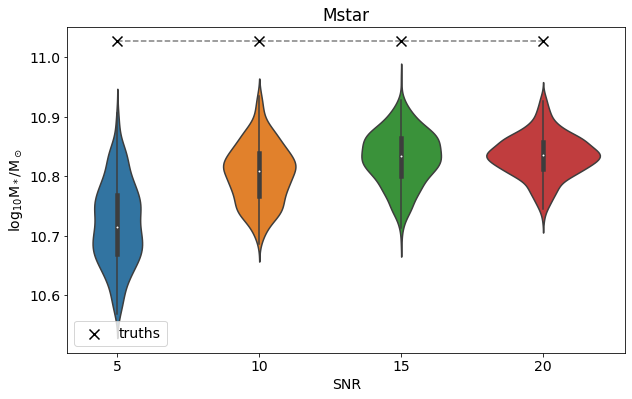

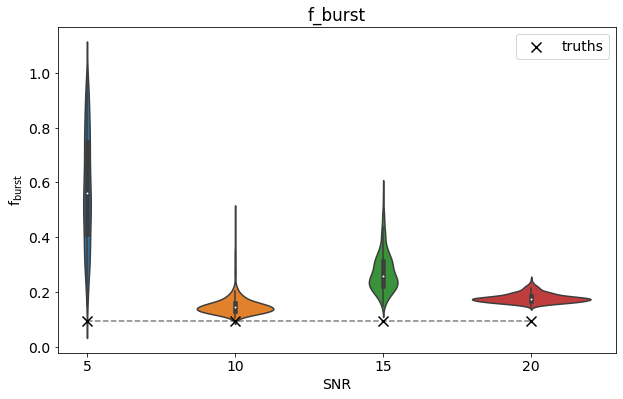

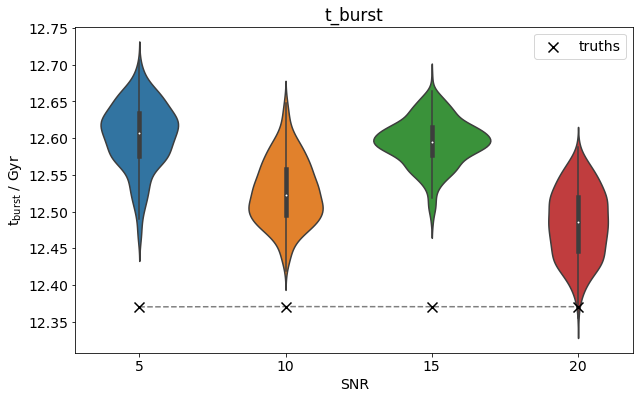

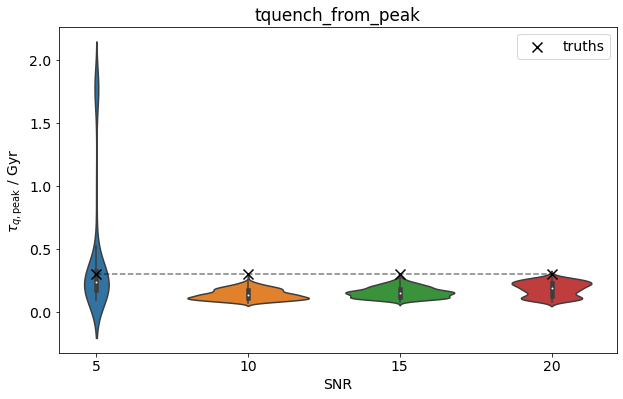

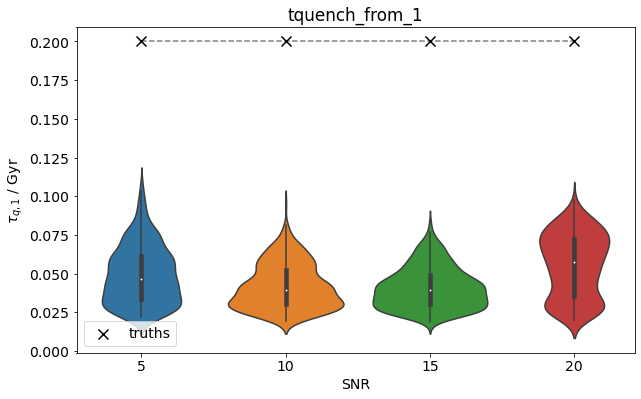

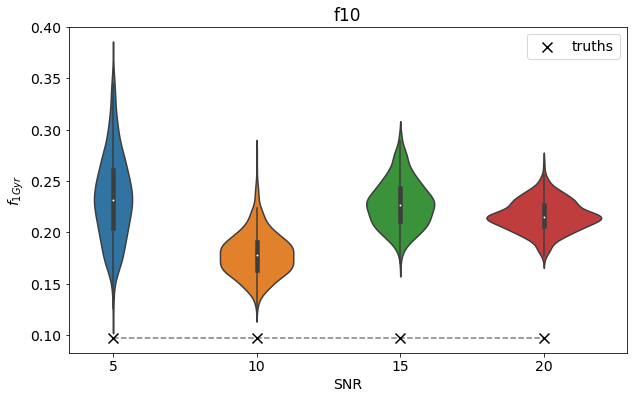

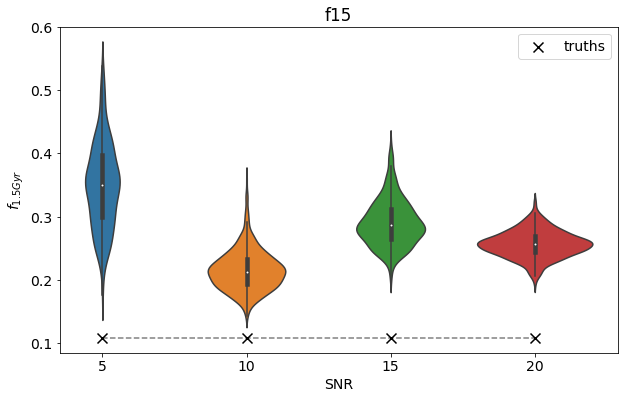

In [22]:
def plot_violin(parameter, post_df, truth_df, ylabel):
    fig, ax = plt.subplots(figsize=[10,6])
    sns.violinplot(x=post_df['SNR'],y=post_df[parameter], ax=ax)
    ax.plot([0,1,2,3], truth_df[parameter].values, 'k--', alpha=0.5)
    ax.scatter([0,1,2,3], truth_df[parameter].values, color='k', marker='x', s=100, zorder=5, label='truths')
    ax.legend()
    #fig.savefig('extra_plots/Yirui_rings_violin_'+parameter+'.pdf')
    ax.set_ylabel(ylabel)
    ax.set_title(parameter)
    plt.rcParams.update({'font.size':14})
    plt.show()

params = ['Mstar', 'f_burst', 't_burst', 'tquench_from_peak', 'tquench_from_1', 'f10', 'f15']
labels = [r'$\log_{10}\rm{M_*/M_\odot}$', r'$\rm{f_{burst}}$', r'$\rm{t_{burst}}$ / Gyr',
         r'$\tau_{q,\rm{peak}}$ / Gyr', r'$\tau_{q,1}$ / Gyr', r'$f_{1Gyr}$', r'$f_{1.5Gyr}$']
for i,param in enumerate(params):
    plot_violin(param, master_df, truth_df, labels[i])